# Stream

## Model Description 
This constructs a 2D steady state box model with a single stream reach
#### Dimensions: 
- 51 by 51 by 1 (note the odd number so that the stream can be centered)
- dx = dy = 100 m
- dz = 10 m  

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x, y and z.
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Stream Properties: 
- Inflow to first reach = 0 m3/d
- Streambed slope = 0.0001 m/m
- Streambed rough = 0.02377
- Streambed width = 20 m
- Streambed K = 0.01 m/day for the rows 0-19, 0.1 for rows 20-25, and 1 for the rest of the stream. 
- Streambed thickness = 1 m
- Stream bottom depth = 7 m

#### Boundary Conditions: 
 - Right boundary is defined head representing a stream that runs 'down' the domain - in the direction of increasing row number.
 - Left boundary is a constant head representing a lake.

# Set up the environment

In [225]:
import flopy
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import flopy.utils.binaryfile as bf

%matplotlib inline

# User inputs

In [226]:
modelname = "str_model"
moddir="C:/WRDAPP/mf2005.1_12/bin/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

nlay = 1
nrow = 51
ncol = 51
dx = 10
dy = 10
ztop = 10
zbot = 0.

dz = (ztop - zbot) / nlay
Lx = dx*ncol
Ly = dy*nrow

nper = 1
steady = [True]

# Build DIS object

In [227]:
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)   #Model unit meters (lenuni = 2) and days (itmuni = 4)

# Build BAS object

In [228]:
#####################################################################
#Create bas object

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1

strt = np.ones((nlay, nrow, ncol), dtype=np.float32)  
strt[:, 0:51, 0] = 2                 #create strt as array of floats 
strt[:, 0:51, -1] = 2                #create strt as array of floats 
#print(np.linspace(10,3,51))
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

# Build PCG object

In [229]:
#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=1000, iter1=2000, relax = 0.7, damp = 0.7)

# Create LPF object

In [230]:
hk = np.ones((nlay,nrow,ncol), dtype=np.float32)      #defining conductivity in m/d
vk = np.ones((nlay,nrow,ncol), dtype=np.float32)

# vk = vk/10
# hk[:,0:25,:] = hk[:,0:25,:]*10
# vk = vk*10

ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage
ss[:,:,:] = 1e-5
n = 0.35
Sy = 0.3
uncnf = 1

lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=hk, 
                               vka=vk, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

# Define RCH object

In [231]:
recharge = 0 #m/day
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[0:26,:]=rech_zone[0:26,:]+recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object

# Define OC object

In [232]:
#####################################################################
#create  output control object 

spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

# Define STR object

In [233]:
#####################################################################
# User inputs:
k_strbott = 1                     #river bottom hydraulic conductivity in f/d
sed_thick = 1                      #thickness of riverbed sediment in f
str_bott = 7                       #river bottom
slope = 0.0001                        #slope of streambed (m/m)
str_bott = np.linspace(str_bott,str_bott - slope*nrow*dy ,51)
#print(str_bott - slope*nrow*dy)
rough = 0.02377                         #roughness of streambed
width = 10.                           #x-sectional width of channel (m)
Flow_into_the_1st_reach = 86400    # m^3/day
Stage_above_datum = 9 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

#####################################################################
# str settings
set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
str_spd1 = []                      #create list to store all river cells for stress period 1
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

#####################################################################
# calculated values
cond = k_strbott*(dy)*(dx)/(sed_thick) #river bed conductance in f^2/d
cond_vals = np.ones(nrow)
cond_vals[0:15] = cond/1
cond_vals[15:30] = cond/1
cond_vals[30:-1] = cond

str_top = str_bott+sed_thick
str_stage = Stage_above_datum

if set_icalc > 0:      #Calculating the stage for graphing using Manning formula
    str_stage = str_top[0] + ((Flow_into_the_1st_reach*rough)/(const*width*(slope**0.5)))**0.6   
    print("Calculated stage at inflow =", str_stage)

#Adding str package with only 1 stress period and one segment
strd = {}  
strspd = []


for x in range(nrow):
    #print(str_bott[x])
    add = [0, x, ncol/2, 1, x+1, Flow_into_the_1st_reach, str_stage, cond_vals[x], str_bott[x], str_top[x], width, slope, rough]
    #add = [0, x, ncol/2, 1, x+1, Flow_into_the_1st_reach, str_stage, cond_vals[x], str_bott, str_top, width, slope, rough]
    strspd.append(add)
strd[0]=strspd   
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

#print(strspd)
strm = flopy.modflow.mfstr.ModflowStr(m, mxacts=75, nss=1, ntrib=0, ndiv=0,icalc= set_icalc, const=const, ipakcb=53,  istcb2=istcb2, dtype=None,
        stress_period_data=strd, segment_data=str_segd, extension='str') 

Calculated stage at inflow = 8.422296526289625


# Plot model grid and boundary conditions

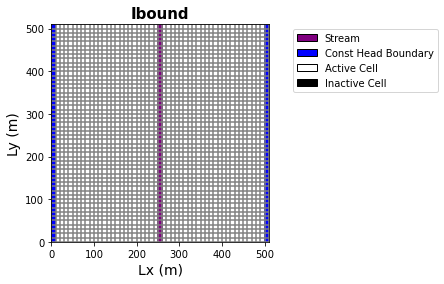

In [234]:
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

# Write MODFLOW input files and run the model

In [235]:
m.write_input()

success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: C:/WRDAPP/mf2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: str_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/04/03 15:20:22

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/04/03 15:20:22
 Elapsed run time:  0.081 Seconds

  Normal termination of simulation


# Plot stream related results 

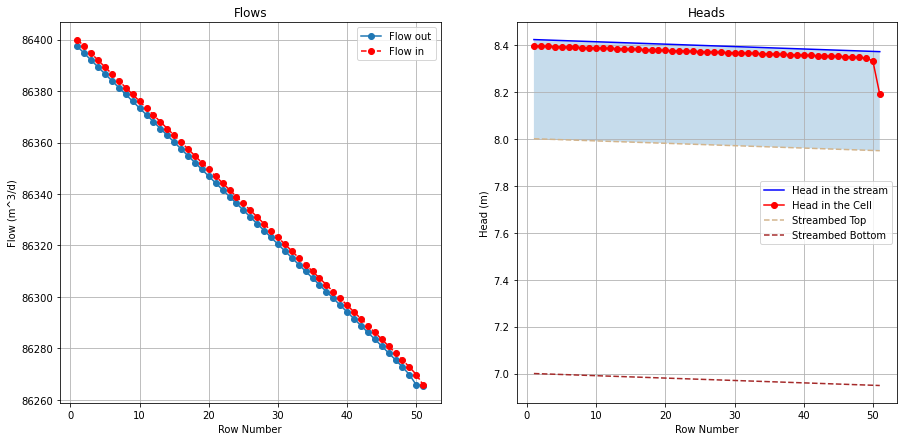

In [236]:
#####################################################################
# Reading budget and head output files
budgobj1 = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
#print(budgobj1.get_unique_record_names())
frf = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
leak = budgobj1.get_data(text='STREAM LEAKAGE', totim=1.0) 

str_outflow = budgobj1.get_data(text='STREAM FLOW OUT', totim=1.0) 
ch_flow = budgobj1.get_data(text='CONSTANT HEAD', totim=1.0) 

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
head = headobj.get_data(totim=1.0)

#####################################################################
#Preparing variables for plotting 
#print(leak)
leakage = leak[0]
str_outflow = str_outflow[0]
str_outflow = str_outflow['q']
str_inflow = str_outflow[:nrow-1]
str_inflow = str_inflow
str_inflow = str_inflow.tolist()
str_inflow.insert(0, Flow_into_the_1st_reach) 
reach = np.arange(0,nrow,1) + 1
head_reach=[]
x_str = strspd[0][2]
x_str=int(x_str)
for i in range(nrow):
    head_reach.append(head[0][i][x_str])


#####################################################################
# Plotting reach wise water budget
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
#ax.set_aspect('equal')
ax1.set_title('Flows')
# ax1.plot(reach, leakage['q'], lw=3, label="Leaked to Aquifer", marker='o') 
ax1.plot(reach, str_outflow, label="Flow out", marker='o') 
ax1.plot(reach, str_inflow, color='red', label="Flow in", linestyle='--', marker='o') 
# ax1.axhline(y=0,  color='black', linestyle='--')
ax1.set_xlabel('Row Number')
#ax1.set_xticks(reach)
ax1.set_ylabel('Flow (m^3/d)')
ax1.legend()
ax1.grid()

#####################################################################
# Plotting reach wise heads
#print(str_inflow)
str_stage = np.zeros(51)
for i in range(nrow):
    #print(str_inflow[i])
    str_stage[i] = ((str_inflow[i]*rough)/(const*width*(slope**0.5)))**0.6 + str_top[i]  
    

ax2.set_title('Heads')
ax2.plot(np.linspace(1, 51 ,51), str_stage,  color='blue', label="Head in the stream")
ax2.plot(reach, head_reach, color='red', label="Head in the Cell", marker='o') 
ax2.plot(np.linspace(1, 51 ,51), str_top, color='tan', linestyle='--', label="Streambed Top")
ax2.plot(np.linspace(1, 51 ,51), str_bott,  color='brown', linestyle='--', label="Streambed Bottom")
plt.fill_between([1, 51], [str_stage[0], str_stage[50]], [str_top[0], str_top[50]], alpha=0.25  )
ax2.set_xlabel('Row Number')
#ax2.set_xticks(reach)
ax2.set_ylabel('Head (m)')
ax2.legend()
ax2.grid()
plt.savefig('Flow balance_ Head across stream.jpg') 



# Plot head distribution

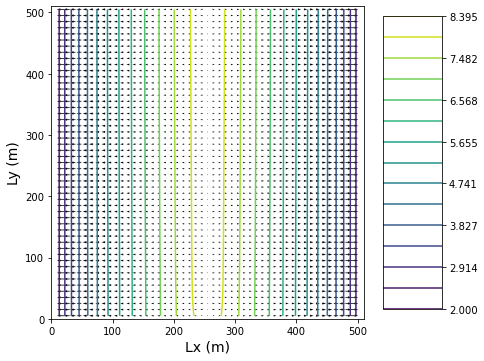

In [237]:
#####################################################################
# Plotting heads and flow arrows
plt.figure(figsize=(7,7)) 
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Steady-State Pumping, Flow(f^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.savefig('equipotential.jpg') 
plt.show(modelmap)

# Cross secction

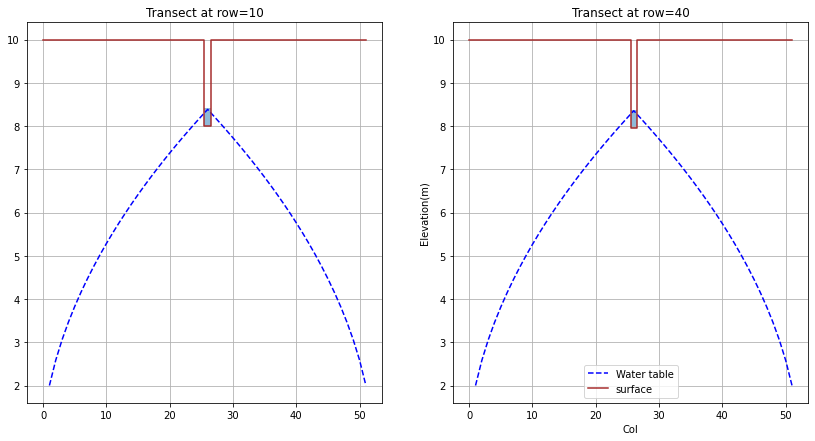

In [238]:
#####################################################################
# Plotting transect
row_transect = 10 
cross_section=[]
for i in range(ncol):
    cross_section.append(head[0][row_transect][i])   
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.plot(np.linspace(1, 51 ,51),cross_section, '--b', label= 'Water table' )
x_stream = [0, 25.5, 25.5, 26.5, 26.5, 51]
y_stream = [ztop, ztop, str_top[row_transect], str_top[row_transect], ztop, ztop]
plt.plot(x_stream, y_stream,   color='brown')
plt.fill_between([25.5, 26.5], [str_stage[row_transect], str_stage[row_transect]], [str_top[row_transect], str_top[row_transect]], alpha=0.5  )
plt.title(f'Transect at row={str(row_transect)}')
plt.grid()



row_transect = 40 
cross_section=[]
for i in range(ncol):
    cross_section.append(head[0][row_transect][i])   
plt.subplot(1, 2, 2)
plt.plot(np.linspace(1, 51 ,51),cross_section, '--b', label= 'Water table' )
x_stream = [0, 25.5, 25.5, 26.5, 26.5, 51]
y_stream = [ztop, ztop, str_top[row_transect], str_top[row_transect], ztop, ztop]
plt.plot(x_stream, y_stream,   color='brown', label='surface')
plt.fill_between([25.5, 26.5], [str_stage[row_transect], str_stage[row_transect]], [str_top[row_transect], str_top[row_transect]], alpha=0.5  )
plt.title(f'Transect at row={str(row_transect)}')
plt.ylabel('Elevation(m)')
plt.xlabel('Col')
plt.legend()
plt.grid()
plt.savefig('transects.jpg') 